In [1]:
import os
import math
import random
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

from typing import List, Tuple, Callable, Optional

import torch 
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import seaborn as sns
import albumentations as albu

from torch.utils.data import DataLoader
from catalyst.contrib.nn.optimizers import RAdam, Lookahead, Adam
from catalyst.dl.callbacks import OptimizerCallback, EarlyStoppingCallback, SchedulerCallback, CheckpointCallback
from catalyst.dl import utils
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from torchvision import transforms as T
from sklearn.metrics import accuracy_score

from models import Effnet
from dataset import ImageDataset
from catalyst_train_fucntions import catalyst_training, catalyst_inference
from callbacks_metric import AccuracyCallback
from callbacks_swa import SWACallback, avarage_weights

%matplotlib inline

In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

## Reproducibility

In [2]:
RS = 42
DEVICE = 'cuda'

In [3]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

utils.set_global_seed(RS)
utils.prepare_cudnn(deterministic=True)
seed_everything(RS)

## Read data

In [4]:
df = pd.read_csv('data/processed_df.csv')
df

,oroginal_path,label,basename,violla_default_pathes,violla_mn5_sf3_pathes,violla_mn1_sfdef_pathes,hog_pathes,cnnalg_pathes,violla_mn5_sf105_pathes
0,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,104.jpg,/ssd_data/celebrity_data/violla/default/Angeli...,NaN,/ssd_data/celebrity_data/violla/mn1_sfdef/Ange...,NaN,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...,/ssd_data/celebrity_data/violla/mn5_sf105/Ange...
1,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,724.jpg,NaN,NaN,NaN,NaN,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...,NaN
2,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,219.jpg,NaN,NaN,NaN,NaN,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...,NaN
3,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,541.jpg,/ssd_data/celebrity_data/violla/default/Angeli...,NaN,/ssd_data/celebrity_data/violla/mn1_sfdef/Ange...,/ssd_data/celebrity_data/hog/Angelina Jolie/54...,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...,/ssd_data/celebrity_data/violla/mn5_sf105/Ange...
4,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,107.jpg,/ssd_data/celebrity_data/violla/default/Angeli...,NaN,/ssd_data/celebrity_data/violla/mn1_sfdef/Ange...,/ssd_data/celebrity_data/hog/Angelina Jolie/10...,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...,/ssd_data/celebrity_data/violla/mn5_sf105/Ange...
...,...,...,...,...,...,...,...,...,...
12155,/ssd_data/cifar10/train/5672.png,no_face,5672.png,/ssd_data/celebrity_data/violla/default/cifar/...,/ssd_data/celebrity_data/violla/mn5_sf3/cifar/...,/ssd_data/celebrity_data/violla/mn1_sfdef/cifa...,/ssd_data/celebrity_data/hog/cifar/5672.png,/ssd_data/celebrity_data/cnnalg/cifar/5672.png,/ssd_data/celebrity_data/violla/mn5_sf105/cifa...
12156,/ssd_data/cifar10/train/48106.png,no_face,48106.png,/ssd_data/celebrity_data/violla/default/cifar/...,/ssd_data/celebrity_data/violla/mn5_sf3/cifar/...,/ssd_data/celebrity_data/violla/mn1_sfdef/cifa...,/ssd_data/celebrity_data/hog/cifar/48106.png,/ssd_data/celebrity_data/cnnalg/cifar/48106.png,/ssd_data/celebrity_data/violla/mn5_sf105/cifa...
12157,/ssd_data/cifar10/train/40719.png,no_face,40719.png,/ssd_data/celebrity_data/violla/default/cifar/...,/ssd_data/celebrity_data/violla/mn5_sf3/cifar/...,/ssd_data/celebrity_data/violla/mn1_sfdef/cifa...,/ssd_data/celebrity_data/hog/cifar/40719.png,/ssd_data/celebrity_data/cnnalg/cifar/40719.png,/ssd_data/celebrity_data/violla/mn5_sf105/cifa...
12158,/ssd_data/cifar10/train/32756.png,no_face,32756.png,/ssd_data/celebrity_data/violla/default/cifar/...,/ssd_data/celebrity_data/violla/mn5_sf3/cifar/...,/ssd_data/celebrity_data/violla/mn1_sfdef/cifa...,/ssd_data/celebrity_data/hog/cifar/32756.png,/ssd_data/celebrity_data/cnnalg/cifar/32756.png,/ssd_data/celebrity_data/violla/mn5_sf105/cifa...


In [5]:
LABEL2ID = {l:i for i,l in enumerate(df.label.unique())}
ID2LABEL = {v:k for k,v in LABEL2ID.items()}
LABEL2ID

{'Angelina Jolie': 0,
 'Adam Sandler': 1,
 'Alan Arkin': 2,
 'Angela Bassett': 3,
 'Alex Pettyfer': 4,
 'Al Pacino': 5,
 'Andy Samberg': 6,
 'Alan Rickman': 7,
 'Anna Friel': 8,
 'Anna Paquin': 9,
 'Andrew Luck': 10,
 'rand_celeb': 11,
 'no_face': 12}

Here we have multiclass task, so we will define each label as separate class

In [7]:
df['label_id'] = df['label'].map(LABEL2ID)
df

,oroginal_path,label,basename,violla_default_pathes,violla_mn5_sf3_pathes,violla_mn1_sfdef_pathes,hog_pathes,cnnalg_pathes,violla_mn5_sf105_pathes,violla_default_pred,label_id
0,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,104.jpg,/ssd_data/celebrity_data/violla/default/Angeli...,NaN,/ssd_data/celebrity_data/violla/mn1_sfdef/Ange...,NaN,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...,/ssd_data/celebrity_data/violla/mn5_sf105/Ange...,None,0
1,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,724.jpg,NaN,NaN,NaN,NaN,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...,NaN,None,0
2,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,219.jpg,NaN,NaN,NaN,NaN,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...,NaN,None,0
3,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,541.jpg,/ssd_data/celebrity_data/violla/default/Angeli...,NaN,/ssd_data/celebrity_data/violla/mn1_sfdef/Ange...,/ssd_data/celebrity_data/hog/Angelina Jolie/54...,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...,/ssd_data/celebrity_data/violla/mn5_sf105/Ange...,None,0
4,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,107.jpg,/ssd_data/celebrity_data/violla/default/Angeli...,NaN,/ssd_data/celebrity_data/violla/mn1_sfdef/Ange...,/ssd_data/celebrity_data/hog/Angelina Jolie/10...,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...,/ssd_data/celebrity_data/violla/mn5_sf105/Ange...,None,0
...,...,...,...,...,...,...,...,...,...,...,...
12155,/ssd_data/cifar10/train/5672.png,no_face,5672.png,/ssd_data/celebrity_data/violla/default/cifar/...,/ssd_data/celebrity_data/violla/mn5_sf3/cifar/...,/ssd_data/celebrity_data/violla/mn1_sfdef/cifa...,/ssd_data/celebrity_data/hog/cifar/5672.png,/ssd_data/celebrity_data/cnnalg/cifar/5672.png,/ssd_data/celebrity_data/violla/mn5_sf105/cifa...,None,12
12156,/ssd_data/cifar10/train/48106.png,no_face,48106.png,/ssd_data/celebrity_data/violla/default/cifar/...,/ssd_data/celebrity_data/violla/mn5_sf3/cifar/...,/ssd_data/celebrity_data/violla/mn1_sfdef/cifa...,/ssd_data/celebrity_data/hog/cifar/48106.png,/ssd_data/celebrity_data/cnnalg/cifar/48106.png,/ssd_data/celebrity_data/violla/mn5_sf105/cifa...,None,12
12157,/ssd_data/cifar10/train/40719.png,no_face,40719.png,/ssd_data/celebrity_data/violla/default/cifar/...,/ssd_data/celebrity_data/violla/mn5_sf3/cifar/...,/ssd_data/celebrity_data/violla/mn1_sfdef/cifa...,/ssd_data/celebrity_data/hog/cifar/40719.png,/ssd_data/celebrity_data/cnnalg/cifar/40719.png,/ssd_data/celebrity_data/violla/mn5_sf105/cifa...,None,12
12158,/ssd_data/cifar10/train/32756.png,no_face,32756.png,/ssd_data/celebrity_data/violla/default/cifar/...,/ssd_data/celebrity_data/violla/mn5_sf3/cifar/...,/ssd_data/celebrity_data/violla/mn1_sfdef/cifa...,/ssd_data/celebrity_data/hog/cifar/32756.png,/ssd_data/celebrity_data/cnnalg/cifar/32756.png,/ssd_data/celebrity_data/violla/mn5_sf105/cifa...,None,12


Now we will prepare prediction columns for each algorithm and put `no_face` label if there is a face but it was not found

In [8]:
PREPROCESS_COLS = [
    'violla_default_pathes', 'violla_mn5_sf3_pathes', 'violla_mn1_sfdef_pathes', 'hog_pathes',
    'cnnalg_pathes', 'violla_mn5_sf105_pathes'
]
for col in PREPROCESS_COLS:
    pred_col = col[:-len('_pathes')] + '_pred'
    df[pred_col] = None
    df.loc[df[col].isna() & (df['label_id'] != 12), pred_col] = 12

In [9]:
df

,oroginal_path,label,basename,violla_default_pathes,violla_mn5_sf3_pathes,violla_mn1_sfdef_pathes,hog_pathes,cnnalg_pathes,violla_mn5_sf105_pathes,violla_default_pred,label_id,violla_mn5_sf3_pred,violla_mn1_sfdef_pred,hog_pred,cnnalg_pred,violla_mn5_sf105_pred
0,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,104.jpg,/ssd_data/celebrity_data/violla/default/Angeli...,NaN,/ssd_data/celebrity_data/violla/mn1_sfdef/Ange...,NaN,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...,/ssd_data/celebrity_data/violla/mn5_sf105/Ange...,None,0,12,None,12,None,None
1,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,724.jpg,NaN,NaN,NaN,NaN,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...,NaN,12,0,12,12,12,None,12
2,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,219.jpg,NaN,NaN,NaN,NaN,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...,NaN,12,0,12,12,12,None,12
3,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,541.jpg,/ssd_data/celebrity_data/violla/default/Angeli...,NaN,/ssd_data/celebrity_data/violla/mn1_sfdef/Ange...,/ssd_data/celebrity_data/hog/Angelina Jolie/54...,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...,/ssd_data/celebrity_data/violla/mn5_sf105/Ange...,None,0,12,None,None,None,None
4,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,107.jpg,/ssd_data/celebrity_data/violla/default/Angeli...,NaN,/ssd_data/celebrity_data/violla/mn1_sfdef/Ange...,/ssd_data/celebrity_data/hog/Angelina Jolie/10...,/ssd_data/celebrity_data/cnnalg/Angelina Jolie...,/ssd_data/celebrity_data/violla/mn5_sf105/Ange...,None,0,12,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12155,/ssd_data/cifar10/train/5672.png,no_face,5672.png,/ssd_data/celebrity_data/violla/default/cifar/...,/ssd_data/celebrity_data/violla/mn5_sf3/cifar/...,/ssd_data/celebrity_data/violla/mn1_sfdef/cifa...,/ssd_data/celebrity_data/hog/cifar/5672.png,/ssd_data/celebrity_data/cnnalg/cifar/5672.png,/ssd_data/celebrity_data/violla/mn5_sf105/cifa...,None,12,None,None,None,None,None
12156,/ssd_data/cifar10/train/48106.png,no_face,48106.png,/ssd_data/celebrity_data/violla/default/cifar/...,/ssd_data/celebrity_data/violla/mn5_sf3/cifar/...,/ssd_data/celebrity_data/violla/mn1_sfdef/cifa...,/ssd_data/celebrity_data/hog/cifar/48106.png,/ssd_data/celebrity_data/cnnalg/cifar/48106.png,/ssd_data/celebrity_data/violla/mn5_sf105/cifa...,None,12,None,None,None,None,None
12157,/ssd_data/cifar10/train/40719.png,no_face,40719.png,/ssd_data/celebrity_data/violla/default/cifar/...,/ssd_data/celebrity_data/violla/mn5_sf3/cifar/...,/ssd_data/celebrity_data/violla/mn1_sfdef/cifa...,/ssd_data/celebrity_data/hog/cifar/40719.png,/ssd_data/celebrity_data/cnnalg/cifar/40719.png,/ssd_data/celebrity_data/violla/mn5_sf105/cifa...,None,12,None,None,None,None,None
12158,/ssd_data/cifar10/train/32756.png,no_face,32756.png,/ssd_data/celebrity_data/violla/default/cifar/...,/ssd_data/celebrity_data/violla/mn5_sf3/cifar/...,/ssd_data/celebrity_data/violla/mn1_sfdef/cifa...,/ssd_data/celebrity_data/hog/cifar/32756.png,/ssd_data/celebrity_data/cnnalg/cifar/32756.png,/ssd_data/celebrity_data/violla/mn5_sf105/cifa...,None,12,None,None,None,None,None


## Train/Test split

In [10]:
def train_test_split(
    df_p: pd.DataFrame,
    split_col: str
):
    cv_policy = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=RS)
    train_idx, test_idx = list(cv_policy.split(df_p, df_p[split_col]))[0]
    
    return (
        df_p.iloc[train_idx].reset_index(drop=True), 
        df_p.iloc[test_idx].reset_index(drop=True)
    )

In [11]:
train_df, test_df = train_test_split(
    df_p=df,
    split_col='label_id'
)

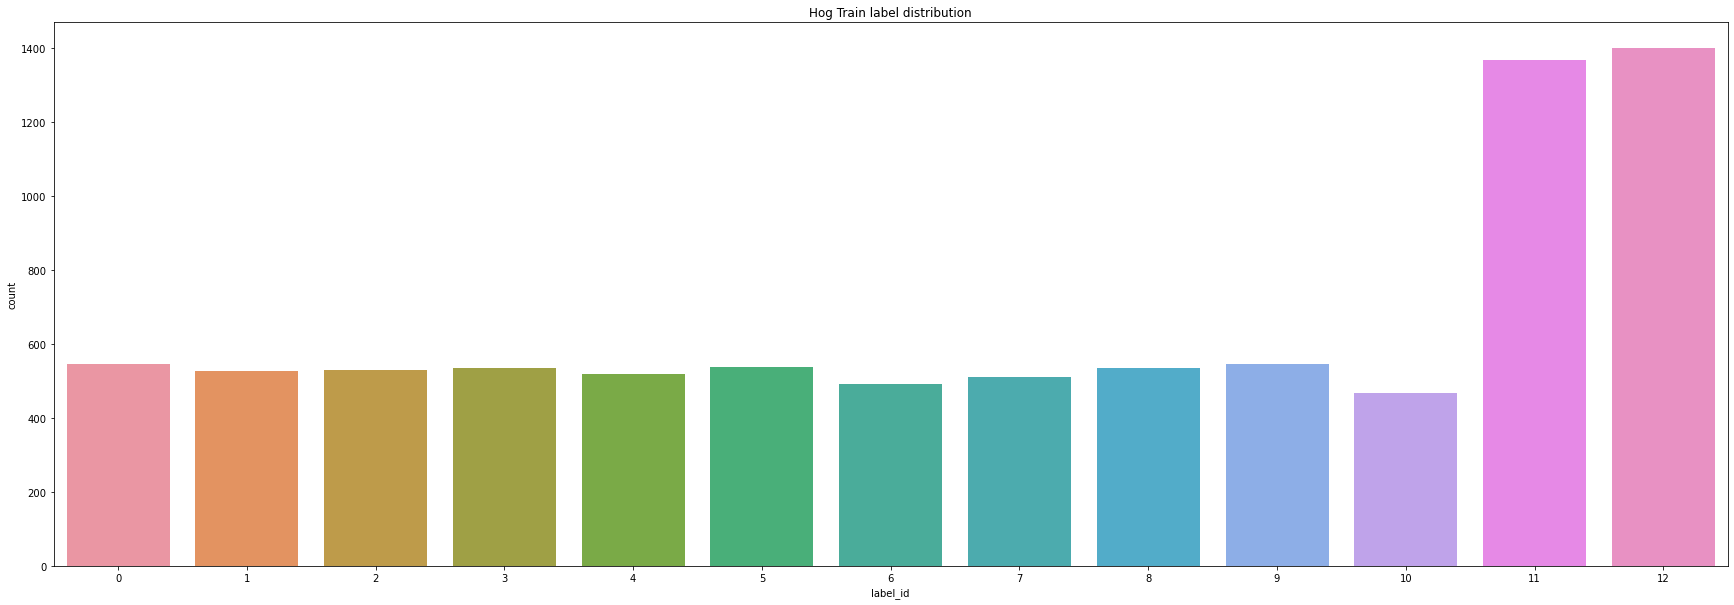

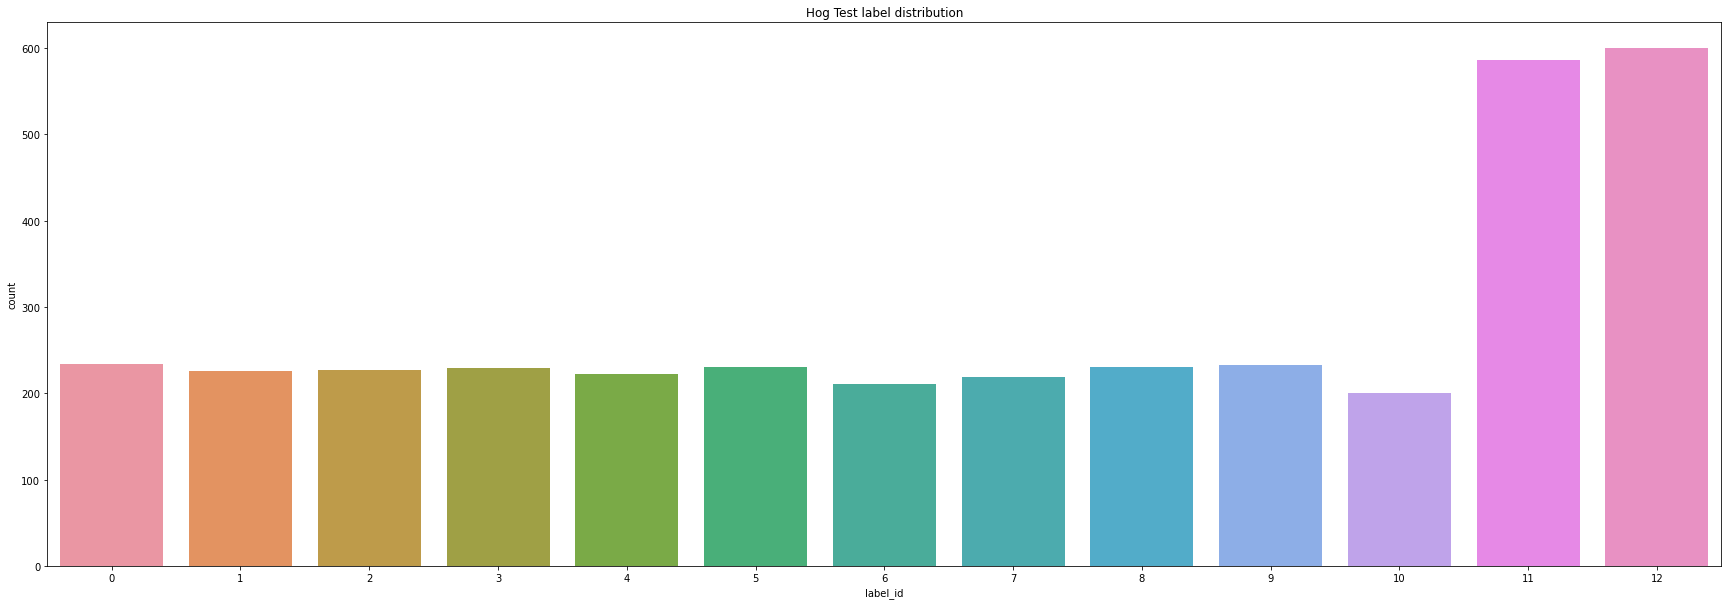

In [12]:
plt.figure(figsize=(30,10))
plt.title("Hog Train label distribution")
sns.countplot(train_df.label_id)
plt.show()

plt.figure(figsize=(30,10))
plt.title("Hog Test label distribution")
sns.countplot(test_df.label_id)
plt.show()

In [13]:
result_df = pd.DataFrame(
    columns=[
        'exp_name', 
        'overall_accuracy_val', 'joli_accuracy_val',
        'overall_accuracy_train', 'joli_accuracy_train',
    ]
)

In [15]:
#!rm logdirs -rf

## Hog dataset

### Train

In [16]:
hog_train_config = {
    "train_df":train_df[~train_df.hog_pathes.isna()].reset_index(drop=True),
    "val_df":test_df[~test_df.hog_pathes.isna()].reset_index(drop=True),
    "exp_name":"logdirs/hog_baseline",
    "train_dataset_class":ImageDataset,
    "train_dataset_config":{
        "path_col":"hog_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                                T.ToTensor(),
                                T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]),
        "augmentations":albu.Compose([
                        albu.HorizontalFlip(p=0.5),
                        albu.VerticalFlip(p=0.5),

                        albu.ShiftScaleRotate(scale_limit=0.3, rotate_limit=0, shift_limit=0.3, p=0.6, border_mode=0),

                        albu.OneOf(
                            [
                                albu.RandomContrast(p=1),
                                albu.HueSaturationValue(p=1),
                            ],
                            p=0.9,
                        ),
                        albu.RandomRotate90()
                    ]),
    },
    "val_dataset_class":ImageDataset,
    "val_dataset_config":{
        "path_col":"hog_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
    },
    "train_dataloader_config":{
        "batch_size":32,
        "shuffle":True,
        "drop_last":True,
        "num_workers":os.cpu_count() // 2
    },
    "val_dataloader_config":{
        "batch_size":32,
        "shuffle":False,
        "drop_last":False,
        "num_workers":os.cpu_count() // 2
    },
    "nn_model_class":Effnet,
    "nn_model_config":{
        "dropout_rate_first":0.2,
        'dropout_rate_second':0.2,
        "mlp_hidden_dim":256,
        "out_channels":13,
        'model_type':'effnet1',
        'classifier_type':'D_L_BN_S_D_L'
    },
    "optimizer_init":lambda model: torch.optim.Adam([
                {'params': model.base_model.parameters(), 'lr': 0.0001},
                {'params': model.classifier.parameters(), 'lr': 0.005}
            ]),
    "scheduler_init":lambda optimizer: torch.optim.lr_scheduler.ReduceLROnPlateau(
                                            optimizer, 
                                            patience=2,
                                            factor=0.25, 
                                            min_lr=1e-6,
                                            mode='max'
                                            ),
    "criterion":nn.CrossEntropyLoss(),
    "n_epochs":60,
    "distributed":False,
    "catalyst_callbacks":lambda : [
        OptimizerCallback(metric_key="loss", accumulation_steps=1),
        AccuracyCallback(overall_accuracy=True, class_accuracy=None),
        AccuracyCallback(overall_accuracy=False, class_accuracy=0),
        EarlyStoppingCallback(patience=7, metric='overall_accuracy', minimize=False),
        SWACallback(
            num_of_swa_models=3,
            maximize=True,
            logging_metric='overall_accuracy',
            verbose=True
        )
    ],
    "main_metric":"overall_accuracy",
    "minimize_metric":False,
    "device":"cuda"
}

In [17]:
hog_runner = catalyst_training(**hog_train_config)

Effnet(
  (base_model): GenEfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SwishJit()
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SwishJit()
          (se): SqueezeExcite(
            (avg_pool): AdaptiveAvgPool2d(output_size=1)
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SwishJit()
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, trac

### Inference

In [18]:
infernce_config_val = {
    "runner":hog_runner,
    "dataset_class":ImageDataset,
    "dataset_config":{
        "df":test_df[~test_df.hog_pathes.isna()].reset_index(drop=True),
        "path_col":"hog_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
    },
    "dataloader_config":{
        "batch_size":32,
        "shuffle":False,
        "drop_last":False,
        "num_workers":os.cpu_count() // 2
    },
    "nn_model_class":Effnet,
    "nn_model_config":{
        "dropout_rate_first":0.2,
        'dropout_rate_second':0.2,
        "mlp_hidden_dim":256,
        "out_channels":13,
        'model_type':'effnet1',
        'classifier_type':'D_L_BN_S_D_L'
    },
    "checkpoint_path":"logdirs/hog_baseline/checkpoints/best.pth",
    "device":"cuda"
}

infernce_config_train = {
    "runner":hog_runner,
    "dataset_class":ImageDataset,
    "dataset_config":{
        "df":train_df[~train_df.hog_pathes.isna()].reset_index(drop=True),
        "path_col":"hog_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
    },
    "dataloader_config":{
        "batch_size":32,
        "shuffle":False,
        "drop_last":False,
        "num_workers":os.cpu_count() // 2
    },
    "nn_model_class":Effnet,
    "nn_model_config":{
        "dropout_rate_first":0.2,
        'dropout_rate_second':0.2,
        "mlp_hidden_dim":256,
        "out_channels":13,
        'model_type':'effnet1',
        'classifier_type':'D_L_BN_S_D_L'
    },
    "checkpoint_path":"logdirs/hog_baseline/checkpoints/best.pth",
    "device":"cuda"
}

In [19]:
hog_val_pred = catalyst_inference(**infernce_config_val)

test_df.loc[~test_df.hog_pathes.isna(), 'hog_pred'] = hog_val_pred.argmax(-1)
test_df['hog_pred'] = test_df['hog_pred'].astype(int)

hog_train_pred = catalyst_inference(**infernce_config_train)

train_df.loc[~train_df.hog_pathes.isna(), 'hog_pred'] = hog_train_pred.argmax(-1)
train_df['hog_pred'] = train_df['hog_pred'].astype(int)

In [20]:
result_df = result_df.append({
    "exp_name":'hog_baseline', 
    "overall_accuracy_val":accuracy_score(test_df.label_id, test_df.hog_pred),
    "joli_accuracy_val":accuracy_score(test_df[test_df.label_id == 0].label_id, test_df[test_df.label_id == 0].hog_pred),
    "overall_accuracy_train":accuracy_score(train_df.label_id, train_df.hog_pred),
    "joli_accuracy_train":accuracy_score(train_df[train_df.label_id == 0].label_id, train_df[train_df.label_id == 0].hog_pred)
}, ignore_index=True)

result_df

,exp_name,overall_accuracy_val,joli_accuracy_val,overall_accuracy_train,joli_accuracy_train
0,hog_baseline,0.770559,0.782051,0.912359,0.869963


## Violla_default dataset

### Train

In [21]:
violla_default_train_config = {
    "train_df":train_df[~train_df.violla_default_pathes.isna()].reset_index(drop=True),
    "val_df":test_df[~test_df.violla_default_pathes.isna()].reset_index(drop=True),
    "exp_name":"logdirs/violla_default_baseline",
    "train_dataset_class":ImageDataset,
    "train_dataset_config":{
        "path_col":"violla_default_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                                T.ToTensor(),
                                T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]),
        "augmentations":albu.Compose([
                        albu.HorizontalFlip(p=0.5),
                        albu.VerticalFlip(p=0.5),

                        albu.ShiftScaleRotate(scale_limit=0.3, rotate_limit=0, shift_limit=0.3, p=0.6, border_mode=0),

                        albu.OneOf(
                            [
                                albu.RandomContrast(p=1),
                                albu.HueSaturationValue(p=1),
                            ],
                            p=0.9,
                        ),
                        albu.RandomRotate90()
                    ]),
    },
    "val_dataset_class":ImageDataset,
    "val_dataset_config":{
        "path_col":"violla_default_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
    },
    "train_dataloader_config":{
        "batch_size":32,
        "shuffle":True,
        "drop_last":True,
        "num_workers":os.cpu_count() // 2
    },
    "val_dataloader_config":{
        "batch_size":32,
        "shuffle":False,
        "drop_last":False,
        "num_workers":os.cpu_count() // 2
    },
    "nn_model_class":Effnet,
    "nn_model_config":{
        "dropout_rate_first":0.2,
        'dropout_rate_second':0.2,
        "mlp_hidden_dim":256,
        "out_channels":13,
        'model_type':'effnet1',
        'classifier_type':'D_L_BN_S_D_L'
    },
    "optimizer_init":lambda model: torch.optim.Adam([
                {'params': model.base_model.parameters(), 'lr': 0.0001},
                {'params': model.classifier.parameters(), 'lr': 0.005}
            ]),
    "scheduler_init":lambda optimizer: torch.optim.lr_scheduler.ReduceLROnPlateau(
                                            optimizer, 
                                            patience=2,
                                            factor=0.25, 
                                            min_lr=1e-6,
                                            mode='max'
                                            ),
    "criterion":nn.CrossEntropyLoss(),
    "n_epochs":60,
    "distributed":False,
    "catalyst_callbacks":lambda : [
        OptimizerCallback(metric_key="loss", accumulation_steps=1),
        AccuracyCallback(overall_accuracy=True, class_accuracy=None),
        AccuracyCallback(overall_accuracy=False, class_accuracy=0),
        EarlyStoppingCallback(patience=7, metric='overall_accuracy', minimize=False),
        SWACallback(
            num_of_swa_models=3,
            maximize=True,
            logging_metric='overall_accuracy',
            verbose=True
        )
    ],
    "main_metric":"overall_accuracy",
    "minimize_metric":False,
    "device":"cuda"
}

In [22]:
violla_default_runner = catalyst_training(**violla_default_train_config)

Effnet(
  (base_model): GenEfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SwishJit()
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SwishJit()
          (se): SqueezeExcite(
            (avg_pool): AdaptiveAvgPool2d(output_size=1)
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SwishJit()
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, trac

### Inference

In [23]:
infernce_config_val = {
    "runner":violla_default_runner,
    "dataset_class":ImageDataset,
    "dataset_config":{
        "df":test_df[~test_df.violla_default_pathes.isna()].reset_index(drop=True),
        "path_col":"violla_default_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
    },
    "dataloader_config":{
        "batch_size":32,
        "shuffle":False,
        "drop_last":False,
        "num_workers":os.cpu_count() // 2
    },
    "nn_model_class":Effnet,
    "nn_model_config":{
        "dropout_rate_first":0.2,
        'dropout_rate_second':0.2,
        "mlp_hidden_dim":256,
        "out_channels":13,
        'model_type':'effnet1',
        'classifier_type':'D_L_BN_S_D_L'
    },
    "checkpoint_path":"logdirs/violla_default_baseline/checkpoints/best.pth",
    "device":"cuda"
}

infernce_config_train = {
    "runner":violla_default_runner,
    "dataset_class":ImageDataset,
    "dataset_config":{
        "df":train_df[~train_df.violla_default_pathes.isna()].reset_index(drop=True),
        "path_col":"violla_default_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
    },
    "dataloader_config":{
        "batch_size":32,
        "shuffle":False,
        "drop_last":False,
        "num_workers":os.cpu_count() // 2
    },
    "nn_model_class":Effnet,
    "nn_model_config":{
        "dropout_rate_first":0.2,
        'dropout_rate_second':0.2,
        "mlp_hidden_dim":256,
        "out_channels":13,
        'model_type':'effnet1',
        'classifier_type':'D_L_BN_S_D_L'
    },
    "checkpoint_path":"logdirs/violla_default_baseline/checkpoints/best.pth",
    "device":"cuda"
}

In [24]:
violla_deafult_val_pred = catalyst_inference(**infernce_config_val)

test_df.loc[~test_df.violla_default_pathes.isna(), 'violla_default_pred'] = violla_deafult_val_pred.argmax(-1)
test_df['violla_default_pred'] = test_df['violla_default_pred'].astype(int)

violla_deafult_train_pred = catalyst_inference(**infernce_config_train)

train_df.loc[~train_df.violla_default_pathes.isna(), 'violla_default_pred'] = violla_deafult_train_pred.argmax(-1)
train_df['violla_default_pred'] = train_df['violla_default_pred'].astype(int)

In [25]:
result_df = result_df.append({
    "exp_name":'violla_default_baseline', 
    "overall_accuracy_val":accuracy_score(test_df.label_id, test_df.violla_default_pred),
    "joli_accuracy_val":accuracy_score(test_df[test_df.label_id == 0].label_id, test_df[test_df.label_id == 0].violla_default_pred),
    "overall_accuracy_train":accuracy_score(train_df.label_id, train_df.violla_default_pred),
    "joli_accuracy_train":accuracy_score(train_df[train_df.label_id == 0].label_id, train_df[train_df.label_id == 0].violla_default_pred)
}, ignore_index=True)

result_df

,exp_name,overall_accuracy_val,joli_accuracy_val,overall_accuracy_train,joli_accuracy_train
0,hog_baseline,0.770559,0.782051,0.912359,0.869963
1,violla_default_baseline,0.703673,0.628205,0.817904,0.723443


## Violla_mn1_sfdef_pathes dataset

### Train

In [26]:
violla_mn1_sfdef_train_config = {
    "train_df":train_df[~train_df.violla_mn1_sfdef_pathes.isna()].reset_index(drop=True),
    "val_df":test_df[~test_df.violla_mn1_sfdef_pathes.isna()].reset_index(drop=True),
    "exp_name":"logdirs/violla_mn1_sfdef_baseline",
    "train_dataset_class":ImageDataset,
    "train_dataset_config":{
        "path_col":"violla_mn1_sfdef_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                                T.ToTensor(),
                                T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]),
        "augmentations":albu.Compose([
                        albu.HorizontalFlip(p=0.5),
                        albu.VerticalFlip(p=0.5),

                        albu.ShiftScaleRotate(scale_limit=0.3, rotate_limit=0, shift_limit=0.3, p=0.6, border_mode=0),

                        albu.OneOf(
                            [
                                albu.RandomContrast(p=1),
                                albu.HueSaturationValue(p=1),
                            ],
                            p=0.9,
                        ),
                        albu.RandomRotate90()
                    ]),
    },
    "val_dataset_class":ImageDataset,
    "val_dataset_config":{
        "path_col":"violla_mn1_sfdef_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
    },
    "train_dataloader_config":{
        "batch_size":32,
        "shuffle":True,
        "drop_last":True,
        "num_workers":os.cpu_count() // 2
    },
    "val_dataloader_config":{
        "batch_size":32,
        "shuffle":False,
        "drop_last":False,
        "num_workers":os.cpu_count() // 2
    },
    "nn_model_class":Effnet,
    "nn_model_config":{
        "dropout_rate_first":0.2,
        'dropout_rate_second':0.2,
        "mlp_hidden_dim":256,
        "out_channels":13,
        'model_type':'effnet1',
        'classifier_type':'D_L_BN_S_D_L'
    },
    "optimizer_init":lambda model: torch.optim.Adam([
                {'params': model.base_model.parameters(), 'lr': 0.0001},
                {'params': model.classifier.parameters(), 'lr': 0.005}
            ]),
    "scheduler_init":lambda optimizer: torch.optim.lr_scheduler.ReduceLROnPlateau(
                                            optimizer, 
                                            patience=2,
                                            factor=0.25, 
                                            min_lr=1e-6,
                                            mode='max'
                                            ),
    "criterion":nn.CrossEntropyLoss(),
    "n_epochs":60,
    "distributed":False,
    "catalyst_callbacks":lambda : [
        OptimizerCallback(metric_key="loss", accumulation_steps=1),
        AccuracyCallback(overall_accuracy=True, class_accuracy=None),
        AccuracyCallback(overall_accuracy=False, class_accuracy=0),
        EarlyStoppingCallback(patience=7, metric='overall_accuracy', minimize=False),
        SWACallback(
            num_of_swa_models=3,
            maximize=True,
            logging_metric='overall_accuracy',
            verbose=True
        )
    ],
    "main_metric":"overall_accuracy",
    "minimize_metric":False,
    "device":"cuda"
}

In [27]:
violla_mn1_sfdef_runner = catalyst_training(**violla_mn1_sfdef_train_config)

Effnet(
  (base_model): GenEfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SwishJit()
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SwishJit()
          (se): SqueezeExcite(
            (avg_pool): AdaptiveAvgPool2d(output_size=1)
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SwishJit()
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, trac

### Inference

In [28]:
infernce_config_val = {
    "runner":violla_mn1_sfdef_runner,
    "dataset_class":ImageDataset,
    "dataset_config":{
        "df":test_df[~test_df.violla_mn1_sfdef_pathes.isna()].reset_index(drop=True),
        "path_col":"violla_mn1_sfdef_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
    },
    "dataloader_config":{
        "batch_size":32,
        "shuffle":False,
        "drop_last":False,
        "num_workers":os.cpu_count() // 2
    },
    "nn_model_class":Effnet,
    "nn_model_config":{
        "dropout_rate_first":0.2,
        'dropout_rate_second':0.2,
        "mlp_hidden_dim":256,
        "out_channels":13,
        'model_type':'effnet1',
        'classifier_type':'D_L_BN_S_D_L'
    },
    "checkpoint_path":"logdirs/violla_mn1_sfdef_baseline/checkpoints/best.pth",
    "device":"cuda"
}

infernce_config_train = {
    "runner":violla_mn1_sfdef_runner,
    "dataset_class":ImageDataset,
    "dataset_config":{
        "df":train_df[~train_df.violla_mn1_sfdef_pathes.isna()].reset_index(drop=True),
        "path_col":"violla_mn1_sfdef_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
    },
    "dataloader_config":{
        "batch_size":32,
        "shuffle":False,
        "drop_last":False,
        "num_workers":os.cpu_count() // 2
    },
    "nn_model_class":Effnet,
    "nn_model_config":{
        "dropout_rate_first":0.2,
        'dropout_rate_second':0.2,
        "mlp_hidden_dim":256,
        "out_channels":13,
        'model_type':'effnet1',
        'classifier_type':'D_L_BN_S_D_L'
    },
    "checkpoint_path":"logdirs/violla_mn1_sfdef_baseline/checkpoints/best.pth",
    "device":"cuda"
}

In [29]:
violla_mn1_sfdef_val_pred = catalyst_inference(**infernce_config_val)

test_df.loc[~test_df.violla_mn1_sfdef_pathes.isna(), 'violla_mn1_sfdef_pred'] = violla_mn1_sfdef_val_pred.argmax(-1)
test_df['violla_mn1_sfdef_pred'] = test_df['violla_mn1_sfdef_pred'].astype(int)

violla_mn1_sfdef_train_pred = catalyst_inference(**infernce_config_train)

train_df.loc[~train_df.violla_mn1_sfdef_pathes.isna(), 'violla_mn1_sfdef_pred'] = violla_mn1_sfdef_train_pred.argmax(-1)
train_df['violla_mn1_sfdef_pred'] = train_df['violla_mn1_sfdef_pred'].astype(int)

In [30]:
result_df = result_df.append({
    "exp_name":'violla_mn1_sfdef_baseline', 
    "overall_accuracy_val":accuracy_score(test_df.label_id, test_df.violla_mn1_sfdef_pred),
    "joli_accuracy_val":accuracy_score(test_df[test_df.label_id == 0].label_id, test_df[test_df.label_id == 0].violla_mn1_sfdef_pred),
    "overall_accuracy_train":accuracy_score(train_df.label_id, train_df.violla_mn1_sfdef_pred),
    "joli_accuracy_train":accuracy_score(train_df[train_df.label_id == 0].label_id, train_df[train_df.label_id == 0].violla_mn1_sfdef_pred)
}, ignore_index=True)

result_df

,exp_name,overall_accuracy_val,joli_accuracy_val,overall_accuracy_train,joli_accuracy_train
0,hog_baseline,0.770559,0.782051,0.912359,0.869963
1,violla_default_baseline,0.703673,0.628205,0.817904,0.723443
2,violla_mn1_sfdef_baseline,0.750548,0.705128,0.910479,0.844322


## Violla_mn5_sf105 dataset

### Train

In [31]:
violla_mn5_sf105_train_config = {
    "train_df":train_df[~train_df.violla_mn5_sf105_pathes.isna()].reset_index(drop=True),
    "val_df":test_df[~test_df.violla_mn5_sf105_pathes.isna()].reset_index(drop=True),
    "exp_name":"logdirs/violla_mn5_sf105_baseline",
    "train_dataset_class":ImageDataset,
    "train_dataset_config":{
        "path_col":"violla_mn5_sf105_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                                T.ToTensor(),
                                T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]),
        "augmentations":albu.Compose([
                        albu.HorizontalFlip(p=0.5),
                        albu.VerticalFlip(p=0.5),

                        albu.ShiftScaleRotate(scale_limit=0.3, rotate_limit=0, shift_limit=0.3, p=0.6, border_mode=0),

                        albu.OneOf(
                            [
                                albu.RandomContrast(p=1),
                                albu.HueSaturationValue(p=1),
                            ],
                            p=0.9,
                        ),
                        albu.RandomRotate90()
                    ]),
    },
    "val_dataset_class":ImageDataset,
    "val_dataset_config":{
        "path_col":"violla_mn5_sf105_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
    },
    "train_dataloader_config":{
        "batch_size":32,
        "shuffle":True,
        "drop_last":True,
        "num_workers":os.cpu_count() // 2
    },
    "val_dataloader_config":{
        "batch_size":32,
        "shuffle":False,
        "drop_last":False,
        "num_workers":os.cpu_count() // 2
    },
    "nn_model_class":Effnet,
    "nn_model_config":{
        "dropout_rate_first":0.2,
        'dropout_rate_second':0.2,
        "mlp_hidden_dim":256,
        "out_channels":13,
        'model_type':'effnet1',
        'classifier_type':'D_L_BN_S_D_L'
    },
    "optimizer_init":lambda model: torch.optim.Adam([
                {'params': model.base_model.parameters(), 'lr': 0.0001},
                {'params': model.classifier.parameters(), 'lr': 0.005}
            ]),
    "scheduler_init":lambda optimizer: torch.optim.lr_scheduler.ReduceLROnPlateau(
                                            optimizer, 
                                            patience=2,
                                            factor=0.25, 
                                            min_lr=1e-6,
                                            mode='max'
                                            ),
    "criterion":nn.CrossEntropyLoss(),
    "n_epochs":60,
    "distributed":False,
    "catalyst_callbacks":lambda : [
        OptimizerCallback(metric_key="loss", accumulation_steps=1),
        AccuracyCallback(overall_accuracy=True, class_accuracy=None),
        AccuracyCallback(overall_accuracy=False, class_accuracy=0),
        EarlyStoppingCallback(patience=7, metric='overall_accuracy', minimize=False),
        SWACallback(
            num_of_swa_models=3,
            maximize=True,
            logging_metric='overall_accuracy',
            verbose=True
        )
    ],
    "main_metric":"overall_accuracy",
    "minimize_metric":False,
    "device":"cuda"
}

In [32]:
violla_mn5_sf105_runner = catalyst_training(**violla_mn5_sf105_train_config)

Effnet(
  (base_model): GenEfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SwishJit()
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SwishJit()
          (se): SqueezeExcite(
            (avg_pool): AdaptiveAvgPool2d(output_size=1)
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SwishJit()
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, trac

### Inference

In [33]:
infernce_config_val = {
    "runner":violla_mn5_sf105_runner,
    "dataset_class":ImageDataset,
    "dataset_config":{
        "df":test_df[~test_df.violla_mn5_sf105_pathes.isna()].reset_index(drop=True),
        "path_col":"violla_mn5_sf105_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
    },
    "dataloader_config":{
        "batch_size":32,
        "shuffle":False,
        "drop_last":False,
        "num_workers":os.cpu_count() // 2
    },
    "nn_model_class":Effnet,
    "nn_model_config":{
        "dropout_rate_first":0.2,
        'dropout_rate_second':0.2,
        "mlp_hidden_dim":256,
        "out_channels":13,
        'model_type':'effnet1',
        'classifier_type':'D_L_BN_S_D_L'
    },
    "checkpoint_path":"logdirs/violla_mn5_sf105_baseline/checkpoints/best.pth",
    "device":"cuda"
}

infernce_config_train = {
    "runner":violla_mn5_sf105_runner,
    "dataset_class":ImageDataset,
    "dataset_config":{
        "df":train_df[~train_df.violla_mn5_sf105_pathes.isna()].reset_index(drop=True),
        "path_col":"violla_mn5_sf105_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
    },
    "dataloader_config":{
        "batch_size":32,
        "shuffle":False,
        "drop_last":False,
        "num_workers":os.cpu_count() // 2
    },
    "nn_model_class":Effnet,
    "nn_model_config":{
        "dropout_rate_first":0.2,
        'dropout_rate_second':0.2,
        "mlp_hidden_dim":256,
        "out_channels":13,
        'model_type':'effnet1',
        'classifier_type':'D_L_BN_S_D_L'
    },
    "checkpoint_path":"logdirs/violla_mn5_sf105_baseline/checkpoints/best.pth",
    "device":"cuda"
}

In [34]:
violla_mn5_sf105_val_pred = catalyst_inference(**infernce_config_val)

test_df.loc[~test_df.violla_mn5_sf105_pathes.isna(), 'violla_mn5_sf105_pred'] = violla_mn5_sf105_val_pred.argmax(-1)
test_df['violla_mn5_sf105_pred'] = test_df['violla_mn5_sf105_pred'].astype(int)

violla_mn5_sf105_train_pred = catalyst_inference(**infernce_config_train)

train_df.loc[~train_df.violla_mn5_sf105_pathes.isna(), 'violla_mn5_sf105_pred'] = violla_mn5_sf105_train_pred.argmax(-1)
train_df['violla_mn5_sf105_pred'] = train_df['violla_mn5_sf105_pred'].astype(int)

In [35]:
result_df = result_df.append({
    "exp_name":'violla_mn5_sf105_baseline', 
    "overall_accuracy_val":accuracy_score(test_df.label_id, test_df.violla_mn5_sf105_pred),
    "joli_accuracy_val":accuracy_score(test_df[test_df.label_id == 0].label_id, test_df[test_df.label_id == 0].violla_mn5_sf105_pred),
    "overall_accuracy_train":accuracy_score(train_df.label_id, train_df.violla_mn5_sf105_pred),
    "joli_accuracy_train":accuracy_score(train_df[train_df.label_id == 0].label_id, train_df[train_df.label_id == 0].violla_mn5_sf105_pred)
}, ignore_index=True)

result_df

,exp_name,overall_accuracy_val,joli_accuracy_val,overall_accuracy_train,joli_accuracy_train
0,hog_baseline,0.770559,0.782051,0.912359,0.869963
1,violla_default_baseline,0.703673,0.628205,0.817904,0.723443
2,violla_mn1_sfdef_baseline,0.750548,0.705128,0.910479,0.844322
3,violla_mn5_sf105_baseline,0.717654,0.670940,0.844807,0.739927


## Cnnalg dataset

### Train

In [36]:
cnnalg_train_config = {
    "train_df":train_df[~train_df.cnnalg_pathes.isna()].reset_index(drop=True),
    "val_df":test_df[~test_df.cnnalg_pathes.isna()].reset_index(drop=True),
    "exp_name":"logdirs/cnnalg_baseline",
    "train_dataset_class":ImageDataset,
    "train_dataset_config":{
        "path_col":"cnnalg_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                                T.ToTensor(),
                                T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]),
        "augmentations":albu.Compose([
                        albu.HorizontalFlip(p=0.5),
                        albu.VerticalFlip(p=0.5),

                        albu.ShiftScaleRotate(scale_limit=0.3, rotate_limit=0, shift_limit=0.3, p=0.6, border_mode=0),

                        albu.OneOf(
                            [
                                albu.RandomContrast(p=1),
                                albu.HueSaturationValue(p=1),
                            ],
                            p=0.9,
                        ),
                        albu.RandomRotate90()
                    ]),
    },
    "val_dataset_class":ImageDataset,
    "val_dataset_config":{
        "path_col":"cnnalg_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
    },
    "train_dataloader_config":{
        "batch_size":32,
        "shuffle":True,
        "drop_last":True,
        "num_workers":os.cpu_count() // 2
    },
    "val_dataloader_config":{
        "batch_size":32,
        "shuffle":False,
        "drop_last":False,
        "num_workers":os.cpu_count() // 2
    },
    "nn_model_class":Effnet,
    "nn_model_config":{
        "dropout_rate_first":0.2,
        'dropout_rate_second':0.2,
        "mlp_hidden_dim":256,
        "out_channels":13,
        'model_type':'effnet1',
        'classifier_type':'D_L_BN_S_D_L'
    },
    "optimizer_init":lambda model: torch.optim.Adam([
                {'params': model.base_model.parameters(), 'lr': 0.0001},
                {'params': model.classifier.parameters(), 'lr': 0.005}
            ]),
    "scheduler_init":lambda optimizer: torch.optim.lr_scheduler.ReduceLROnPlateau(
                                            optimizer, 
                                            patience=2,
                                            factor=0.25, 
                                            min_lr=1e-6,
                                            mode='max'
                                            ),
    "criterion":nn.CrossEntropyLoss(),
    "n_epochs":60,
    "distributed":False,
    "catalyst_callbacks":lambda : [
        OptimizerCallback(metric_key="loss", accumulation_steps=1),
        AccuracyCallback(overall_accuracy=True, class_accuracy=None),
        AccuracyCallback(overall_accuracy=False, class_accuracy=0),
        EarlyStoppingCallback(patience=7, metric='overall_accuracy', minimize=False),
        SWACallback(
            num_of_swa_models=3,
            maximize=True,
            logging_metric='overall_accuracy',
            verbose=True
        )
    ],
    "main_metric":"overall_accuracy",
    "minimize_metric":False,
    "device":"cuda"
}

In [37]:
cnnalg_runner = catalyst_training(**cnnalg_train_config)

Effnet(
  (base_model): GenEfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SwishJit()
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SwishJit()
          (se): SqueezeExcite(
            (avg_pool): AdaptiveAvgPool2d(output_size=1)
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SwishJit()
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, trac

### Inference

In [38]:
infernce_config_val = {
    "runner":cnnalg_runner,
    "dataset_class":ImageDataset,
    "dataset_config":{
        "df":test_df[~test_df.cnnalg_pathes.isna()].reset_index(drop=True),
        "path_col":"cnnalg_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
    },
    "dataloader_config":{
        "batch_size":32,
        "shuffle":False,
        "drop_last":False,
        "num_workers":os.cpu_count() // 2
    },
    "nn_model_class":Effnet,
    "nn_model_config":{
        "dropout_rate_first":0.2,
        'dropout_rate_second':0.2,
        "mlp_hidden_dim":256,
        "out_channels":13,
        'model_type':'effnet1',
        'classifier_type':'D_L_BN_S_D_L'
    },
    "checkpoint_path":"logdirs/cnnalg_baseline/checkpoints/best.pth",
    "device":"cuda"
}

infernce_config_train = {
    "runner":cnnalg_runner,
    "dataset_class":ImageDataset,
    "dataset_config":{
        "df":train_df[~train_df.cnnalg_pathes.isna()].reset_index(drop=True),
        "path_col":"cnnalg_pathes",
        "target_col":"label_id",
        "transforms":T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
    },
    "dataloader_config":{
        "batch_size":32,
        "shuffle":False,
        "drop_last":False,
        "num_workers":os.cpu_count() // 2
    },
    "nn_model_class":Effnet,
    "nn_model_config":{
        "dropout_rate_first":0.2,
        'dropout_rate_second':0.2,
        "mlp_hidden_dim":256,
        "out_channels":13,
        'model_type':'effnet1',
        'classifier_type':'D_L_BN_S_D_L'
    },
    "checkpoint_path":"logdirs/cnnalg_baseline/checkpoints/best.pth",
    "device":"cuda"
}

In [39]:
cnnalg_val_pred = catalyst_inference(**infernce_config_val)

test_df.loc[~test_df.cnnalg_pathes.isna(), 'cnnalg_pred'] = cnnalg_val_pred.argmax(-1)
test_df['cnnalg_pred'] = test_df['cnnalg_pred'].astype(int)

cnnalg_train_pred = catalyst_inference(**infernce_config_train)

train_df.loc[~train_df.cnnalg_pathes.isna(), 'cnnalg_pred'] = cnnalg_train_pred.argmax(-1)
train_df['cnnalg_pred'] = train_df['cnnalg_pred'].astype(int)

In [40]:
result_df = result_df.append({
    "exp_name":'cnnalg_baseline', 
    "overall_accuracy_val":accuracy_score(test_df.label_id, test_df.cnnalg_pred),
    "joli_accuracy_val":accuracy_score(test_df[test_df.label_id == 0].label_id, test_df[test_df.label_id == 0].cnnalg_pred),
    "overall_accuracy_train":accuracy_score(train_df.label_id, train_df.cnnalg_pred),
    "joli_accuracy_train":accuracy_score(train_df[train_df.label_id == 0].label_id, train_df[train_df.label_id == 0].cnnalg_pred)
}, ignore_index=True)

result_df

,exp_name,overall_accuracy_val,joli_accuracy_val,overall_accuracy_train,joli_accuracy_train
0,hog_baseline,0.770559,0.782051,0.912359,0.869963
1,violla_default_baseline,0.703673,0.628205,0.817904,0.723443
2,violla_mn1_sfdef_baseline,0.750548,0.705128,0.910479,0.844322
3,violla_mn5_sf105_baseline,0.717654,0.670940,0.844807,0.739927
4,cnnalg_baseline,0.812500,0.850427,0.973214,0.976190


## Sort and Save

In [41]:
result_df.sort_values('joli_accuracy_val', ascending=False)

,exp_name,overall_accuracy_val,joli_accuracy_val,overall_accuracy_train,joli_accuracy_train
4,cnnalg_baseline,0.812500,0.850427,0.973214,0.976190
0,hog_baseline,0.770559,0.782051,0.912359,0.869963
2,violla_mn1_sfdef_baseline,0.750548,0.705128,0.910479,0.844322
3,violla_mn5_sf105_baseline,0.717654,0.670940,0.844807,0.739927
1,violla_default_baseline,0.703673,0.628205,0.817904,0.723443


In [42]:
result_df.to_csv('data/nn_result_df.csv', index=False)